# Intuit Quickbooks Upgrade

* Team-lead GitLab userid: qchu
* Group name: WonderFourEver
* Team member names: 
    - Chenyuan Liu
    - Qi Chu
    - Xiangyu Zhuang
    - Xinshu Jiang

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

In [2]:
from scipy.stats import chisquare
import keras
# import tensorflow as tf
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from keras import optimizers
from keras.metrics import AUC, Recall, Precision
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras import backend as K
from keras.models import load_model

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier
import shap
import seaborn as sns

from tqdm.notebook import tqdm
import pickle

#### load data

In [3]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


In [4]:
logit_df = pd.read_csv("data/logit_features.csv")
rf_df = pd.read_csv("data/rf_features.csv").iloc[:, 1:]
gbdt_df = pd.read_csv("data/gbdt_features.csv")
sklearn_df = pd.read_csv("data/nn_features.csv").iloc[:, 1:]
kears_40_df = pd.read_csv("data/keras_features_40.csv")

In [5]:
df = intuit75k.copy()

In [6]:
eval_df = df[['id', 'training', 'res1_yes']].copy()

### Logistic

In [7]:
formula = "res1_yes ~ " + ' + '.join(logit_df)
print("Best Logistic:\n", formula)
lr = smf.glm(
    formula=formula,
    family=Binomial(link=logit()),
    data=pd.concat([df[['training', 'res1_yes']], logit_df], axis = 1).query("training == 1"),
).fit()

Best Logistic:
 res1_yes ~ zip_bins + numords + dollars + last + owntaxprod + version1 + upgraded + zip_00801 + zip_00804 + version1_numords + version1_last


In [8]:
eval_df['logit'] = lr.predict(pd.concat([df[['training', 'res1_yes']], logit_df], axis = 1)[logit_df.columns.tolist()])

### RandomForest

In [9]:
rf_clf = pickle.load(open('data/rf.sav', 'rb'))
rf_features = [i for i in rf_df.columns.to_list() if i not in ['res1', 'training'] ]

In [10]:
print("Best parameters achieved by Random Forest:")
rf_clf

Best parameters achieved by Random Forest:


RandomForestClassifier(max_depth=9, max_features=3, min_samples_leaf=10,
                       min_samples_split=3, n_estimators=125)

In [11]:
eval_df['rf'] = rf_clf.predict_proba(rf_df[rf_features])[:, 1]

### GBDT

In [12]:
gbdt_clf = pickle.load(open("data/gbdt_updated.sav", "rb"))
gbdt_features = [i for i in gbdt_df.columns.tolist() if i not in ['training', 'res1_yes']]

Best params obtained by GBDT:

GradientBoostingClassifier(criterion = 'friedman_mse',
    learning_rate = 0.1, 
    loss = 'deviance',
    max_depth = 3,
    max_features = None,
    min_samples_leaf = 5,
    min_samples_split = 50,
    n_estimators = 100,
    validation_fraction = 0.1,
    random_state = 2022,
    subsample = 1.0
)

In [13]:
eval_df['gbdt'] = gbdt_clf.predict_proba(gbdt_df[gbdt_features])[:, 1]

### sklearn NN

In [14]:
nn_clf = pickle.load(open("data/sklearn_nn.sav", "rb"))

In [15]:
print("Best parameters achieved by sklearan NN:")
nn_clf

Best parameters achieved by sklearan NN:


MLPClassifier(activation='tanh', alpha=1, hidden_layer_sizes=(2,),
              learning_rate='adaptive', max_iter=2000, random_state=233,
              solver='lbfgs')

In [16]:
eval_df['sklearn_nn'] = nn_clf.predict_proba(sklearn_df.iloc[:, :-2])[:, 1]

### Keras NN

In [17]:
# dependent functions
def profit_func(y_true, y_pred, margin = 60, cost = 1.14):
    breakeven = cost / margin
    y_pred = K.cast(y_pred >= breakeven, K.floatx())
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis = 1)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis = 1)
    profit = true_positives * margin - (true_positives + false_positives) * cost

    return profit

def recall_m(y_true, y_pred, margin = 60, cost = 1.14):
    breakeven = cost / margin
    y_pred = K.cast(y_pred >= breakeven, K.floatx())
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred, margin = 60, cost = 1.14):
    breakeven = cost / margin
    y_pred = K.cast(y_pred >= breakeven, K.floatx())
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred, margin = 60, cost = 1.1):
    breakeven = cost / margin
    y_pred = K.cast(y_pred >= breakeven, K.floatx())
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
# load model
K.clear_session()
dependencies = {
    'profit_func': profit_func,
    'recall_m': recall_m,
    'precision_m': precision_m,
    'f1_m': f1_m
}
model = load_model("data/keras_nn_0213.h5", custom_objects=dependencies)
# model = load_model("models/keras_mlp.h5", custom_objects=dependencies)

Best params of Keras NN:
- Input Layer: 40 features
- Hidden Layer1: 9 nodes, 'relu' activation function
- Hidden Layer2: 5 nodes, 'relu' activation function
- Output Layer: 1, 'sigmoid' function
- Batch size = 0.05 * int(Xtrain.shape[0] * 0.05)
- epochs = 80, 
- validation_split = 0.1, 
- callbacks = EarlyStopping(patience = 10)

In [19]:
eval_df['keras_nn'] = model.predict(kears_40_df.iloc[:, :-2])

### Ensemble

In [20]:
cost = 1.41
margin = 60
breakeven = cost / margin
avg_weight = 1 / 5

In [21]:
def vote(x, breakeven, pos = 1, neg = 0):
    pos = np.where(x.logit > breakeven, 1, 0) +\
        np.where(x.rf > breakeven, 1, 0) +\
        np.where(x.gbdt > breakeven, 1, 0) +\
        np.where(x.sklearn_nn > breakeven, 1, 0) +\
        np.where(x.keras_nn > breakeven, 1, 0)
    if pos > 5 - pos:
        return 1
    else: return 0

In [22]:
eval_df['vote'] = eval_df.apply(lambda x: vote(x, breakeven), axis = 1)
eval_df['avg_score'] = avg_weight * eval_df.logit + avg_weight * eval_df.rf + avg_weight * eval_df.gbdt + avg_weight * eval_df.sklearn_nn + avg_weight * eval_df.keras_nn

In [23]:
logit_eval = rsm.evalbin(df = eval_df.query("training == 0"), 
            rvar = 'res1_yes', 
            lev = 1, 
            pred = 'logit', 
            cost = 1.41, 
            margin = 60, 
            dec=6)
logit_eval

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,All,logit,948,12320,9077,155,22500,0.859474,0.424218,0.07145,0.131932,0.445556,0.045535,38172.12,1.0,2.04043,0.589689,0.766019


In [24]:
rf_eval = rsm.evalbin(df = eval_df.query("training == 0"), 
            rvar = 'res1_yes', 
            lev = 1, 
            pred = 'rf', 
            cost = 1.41, 
            margin = 60, 
            dec=6)
rf_eval

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,All,rf,940,12259,9138,163,22500,0.852221,0.427069,0.071218,0.13145,0.447911,0.045043,37789.41,1.0,2.030533,0.586622,0.754457


In [25]:
gbdt_eval = rsm.evalbin(df = eval_df.query("training == 0"), 
            rvar = 'res1_yes', 
            lev = 1, 
            pred = 'gbdt', 
            cost = 1.41, 
            margin = 60, 
            dec=6)
gbdt_eval

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,All,gbdt,953,12140,9257,150,22500,0.864007,0.432631,0.072787,0.134263,0.453778,0.048195,38718.87,1.0,2.097319,0.581911,0.766136


In [26]:
sklearn_nn_eval = rsm.evalbin(df = eval_df.query("training == 0"), 
            rvar = 'res1_yes', 
            lev = 1, 
            pred = 'sklearn_nn', 
            cost = 1.41, 
            margin = 60, 
            dec=6)
sklearn_nn_eval

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,All,sklearn_nn,921,11242,10155,182,22500,0.834995,0.474599,0.075721,0.138851,0.492267,0.053794,38110.17,1.0,2.222189,0.540578,0.766425


In [27]:
keras_nn_eval = rsm.evalbin(df = eval_df.query("training == 0"), 
            rvar = 'res1_yes', 
            lev = 1, 
            pred = 'keras_nn', 
            cost = 1.41, 
            margin = 60, 
            dec=6)
keras_nn_eval

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,All,keras_nn,952,11986,9411,151,22500,0.863101,0.439828,0.073582,0.135603,0.460578,0.049755,38877.42,1.0,2.131136,0.575022,0.766405


In [28]:
eval_df.head()

,id,training,res1_yes,logit,rf,gbdt,sklearn_nn,keras_nn,vote,avg_score
0,1,1,0,0.032378,0.026952,0.033468,0.042803,0.041980,1,0.035516
1,2,0,0,0.026388,0.031904,0.027416,0.026307,0.028455,1,0.028094
2,3,0,0,0.079115,0.071932,0.068859,0.066830,0.082331,1,0.073813
3,4,1,0,0.015166,0.168128,0.016819,0.013100,0.016997,0,0.046042
4,5,0,0,0.027008,0.026479,0.025758,0.020576,0.024242,1,0.024812


**vote**

In [29]:
from sklearn.metrics import f1_score, precision_score, accuracy_score, confusion_matrix, auc, roc_curve
fscore = f1_score(eval_df.query("training == 0").res1_yes, eval_df.query("training == 0").vote)
precision = precision_score(eval_df.query("training == 0").res1_yes, eval_df.query("training == 0").vote)
accuracy = accuracy_score(eval_df.query("training == 0").res1_yes, eval_df.query("training == 0").vote)
tn, fp, fn, tp = confusion_matrix(eval_df.query("training == 0").res1_yes, eval_df.query("training == 0").vote).ravel()
# fpr, tpr, thresholds = roc_curve(dfm[rvar], dfm[pm], pos_label=lev)

profit = tp * margin - (tp + fp) * cost
ROME = profit / (cost * (tp + fp))
contact = (tp + fp) / (tp + fp + tn + fn)
vote_eval = pd.DataFrame().assign(
    Type = ['All'],
    predictor = ['vote'],
    TP = [tp], FP = [fp], TN = [tn], FN = [fn], total = [tn + fp + fn + tp],
    TPR = [tp / (tp + fn)], TNR = [tn / (tn + fp)],
    precision = [precision], Fscore = [fscore],
    accuracy = [accuracy], kappa = [None],
    profit = [profit], 
    index = [1],
    ROME = [ROME],
    contact = [contact], #AUC = [auc(fpr, tpr)]
    AUC = [None]
)
vote_eval

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,All,vote,948,11915,9482,155,22500,0.859474,0.443146,0.0737,0.135758,0.463556,None,38743.17,1,2.13616,0.571689,None


**avg_score**

In [30]:
avg_eval = rsm.evalbin(df = eval_df.query("training == 0"), 
            rvar = 'res1_yes', 
            lev = 1, 
            pred = 'avg_score', 
            cost = 1.41, 
            margin = 60, 
            dec=6)
avg_eval

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,All,avg_score,951,12439,8958,152,22500,0.862194,0.418657,0.071023,0.131236,0.4404,0.044702,38180.1,1.0,2.022262,0.595111,0.766981


In [31]:
eval_df.head()

,id,training,res1_yes,logit,rf,gbdt,sklearn_nn,keras_nn,vote,avg_score
0,1,1,0,0.032378,0.026952,0.033468,0.042803,0.041980,1,0.035516
1,2,0,0,0.026388,0.031904,0.027416,0.026307,0.028455,1,0.028094
2,3,0,0,0.079115,0.071932,0.068859,0.066830,0.082331,1,0.073813
3,4,1,0,0.015166,0.168128,0.016819,0.013100,0.016997,0,0.046042
4,5,0,0,0.027008,0.026479,0.025758,0.020576,0.024242,1,0.024812


**Linear Ensemble**

In [32]:
formula = "res1_yes ~ logit + rf + gbdt + sklearn_nn + keras_nn"
print(formula)
lr_model = smf.ols(
    formula=formula,
    data=eval_df.query("training == 1"),
).fit()
lr_model.summary()

res1_yes ~ logit + rf + gbdt + sklearn_nn + keras_nn


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               res1_yes   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     1788.
Date:                Thu, 17 Feb 2022   Prob (F-statistic):               0.00
Time:                        08:42:28   Log-Likelihood:                 10854.
No. Observations:               52500   AIC:                        -2.170e+04
Df Residuals:                   52494   BIC:                        -2.164e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0126      0.001    -10.750      0.000      -0.015      -0.010
logit         -0.5637      0.057     -9.888      0.000      -0.675      -0.452
rf             0.5871      0.027     22.147      0.000       0.535       0.639
gbdt           1.3028      0.048     26.934      0.000       1.208       1.398
sklearn_nn    -0.0228      0.051     -0.451      0.652      -0.122       0.076
keras_nn      -0.0420      0.055     -0.762      0.446      -0.150       0.066
==============================================================================
Omnibus:                    40299.282   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           650666.778
Skew:                           3.731   Prob(JB):                         0.00
Kurtosis:                      18.549   Cond. No.                         84.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
eval_df

,id,training,res1_yes,logit,rf,gbdt,sklearn_nn,keras_nn,vote,avg_score
0,1,1,0,0.032378,0.026952,0.033468,0.042803,0.041980,1,0.035516
1,2,0,0,0.026388,0.031904,0.027416,0.026307,0.028455,1,0.028094
2,3,0,0,0.079115,0.071932,0.068859,0.066830,0.082331,1,0.073813
3,4,1,0,0.015166,0.168128,0.016819,0.013100,0.016997,0,0.046042
4,5,0,0,0.027008,0.026479,0.025758,0.020576,0.024242,1,0.024812
...,...,...,...,...,...,...,...,...,...,...
74995,74996,1,1,0.045130,0.056852,0.049654,0.042587,0.037069,1,0.046259
74996,74997,1,0,0.004450,0.014079,0.011988,0.013467,0.005071,0,0.009811
74997,74998,1,0,0.046705,0.096518,0.068594,0.060833,0.046712,1,0.063872
74998,74999,1,0,0.040906,0.046357,0.045918,0.049505,0.032987,1,0.043135


In [34]:
eval_df['ols_score'] = lr_model.predict(eval_df.iloc[:, 3:8])
ols_eval = rsm.evalbin(df = eval_df.query("training == 0"),\
            rvar = 'res1_yes',
            lev = 1, 
            pred = 'ols_score', 
            cost = 1.41, 
            margin = 60, 
            dec=6)
ols_eval

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,All,ols_score,878,9966,11431,225,22500,0.796011,0.534234,0.080966,0.146983,0.547067,0.063655,37389.96,1.0,2.44538,0.481956,0.755134


In [35]:
final_result = pd.concat([logit_eval, rf_eval, gbdt_eval, sklearn_nn_eval, keras_nn_eval, avg_eval, ols_eval, vote_eval])
final_result.sort_values(by = ['profit', 'ROME'], ascending = [False, False], inplace = True)
final_result

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,All,keras_nn,952,11986,9411,151,22500,0.863101,0.439828,0.073582,0.135603,0.460578,0.049755,38877.42,1.0,2.131136,0.575022,0.766405
0,All,vote,948,11915,9482,155,22500,0.859474,0.443146,0.073700,0.135758,0.463556,None,38743.17,1.0,2.136160,0.571689,None
0,All,gbdt,953,12140,9257,150,22500,0.864007,0.432631,0.072787,0.134263,0.453778,0.048195,38718.87,1.0,2.097319,0.581911,0.766136
0,All,avg_score,951,12439,8958,152,22500,0.862194,0.418657,0.071023,0.131236,0.440400,0.044702,38180.10,1.0,2.022262,0.595111,0.766981
0,All,logit,948,12320,9077,155,22500,0.859474,0.424218,0.071450,0.131932,0.445556,0.045535,38172.12,1.0,2.040430,0.589689,0.766019
0,All,sklearn_nn,921,11242,10155,182,22500,0.834995,0.474599,0.075721,0.138851,0.492267,0.053794,38110.17,1.0,2.222189,0.540578,0.766425
0,All,rf,940,12259,9138,163,22500,0.852221,0.427069,0.071218,0.131450,0.447911,0.045043,37789.41,1.0,2.030533,0.586622,0.754457
0,All,ols_score,878,9966,11431,225,22500,0.796011,0.534234,0.080966,0.146983,0.547067,0.063655,37389.96,1.0,2.445380,0.481956,0.755134


#### Plot the prediction

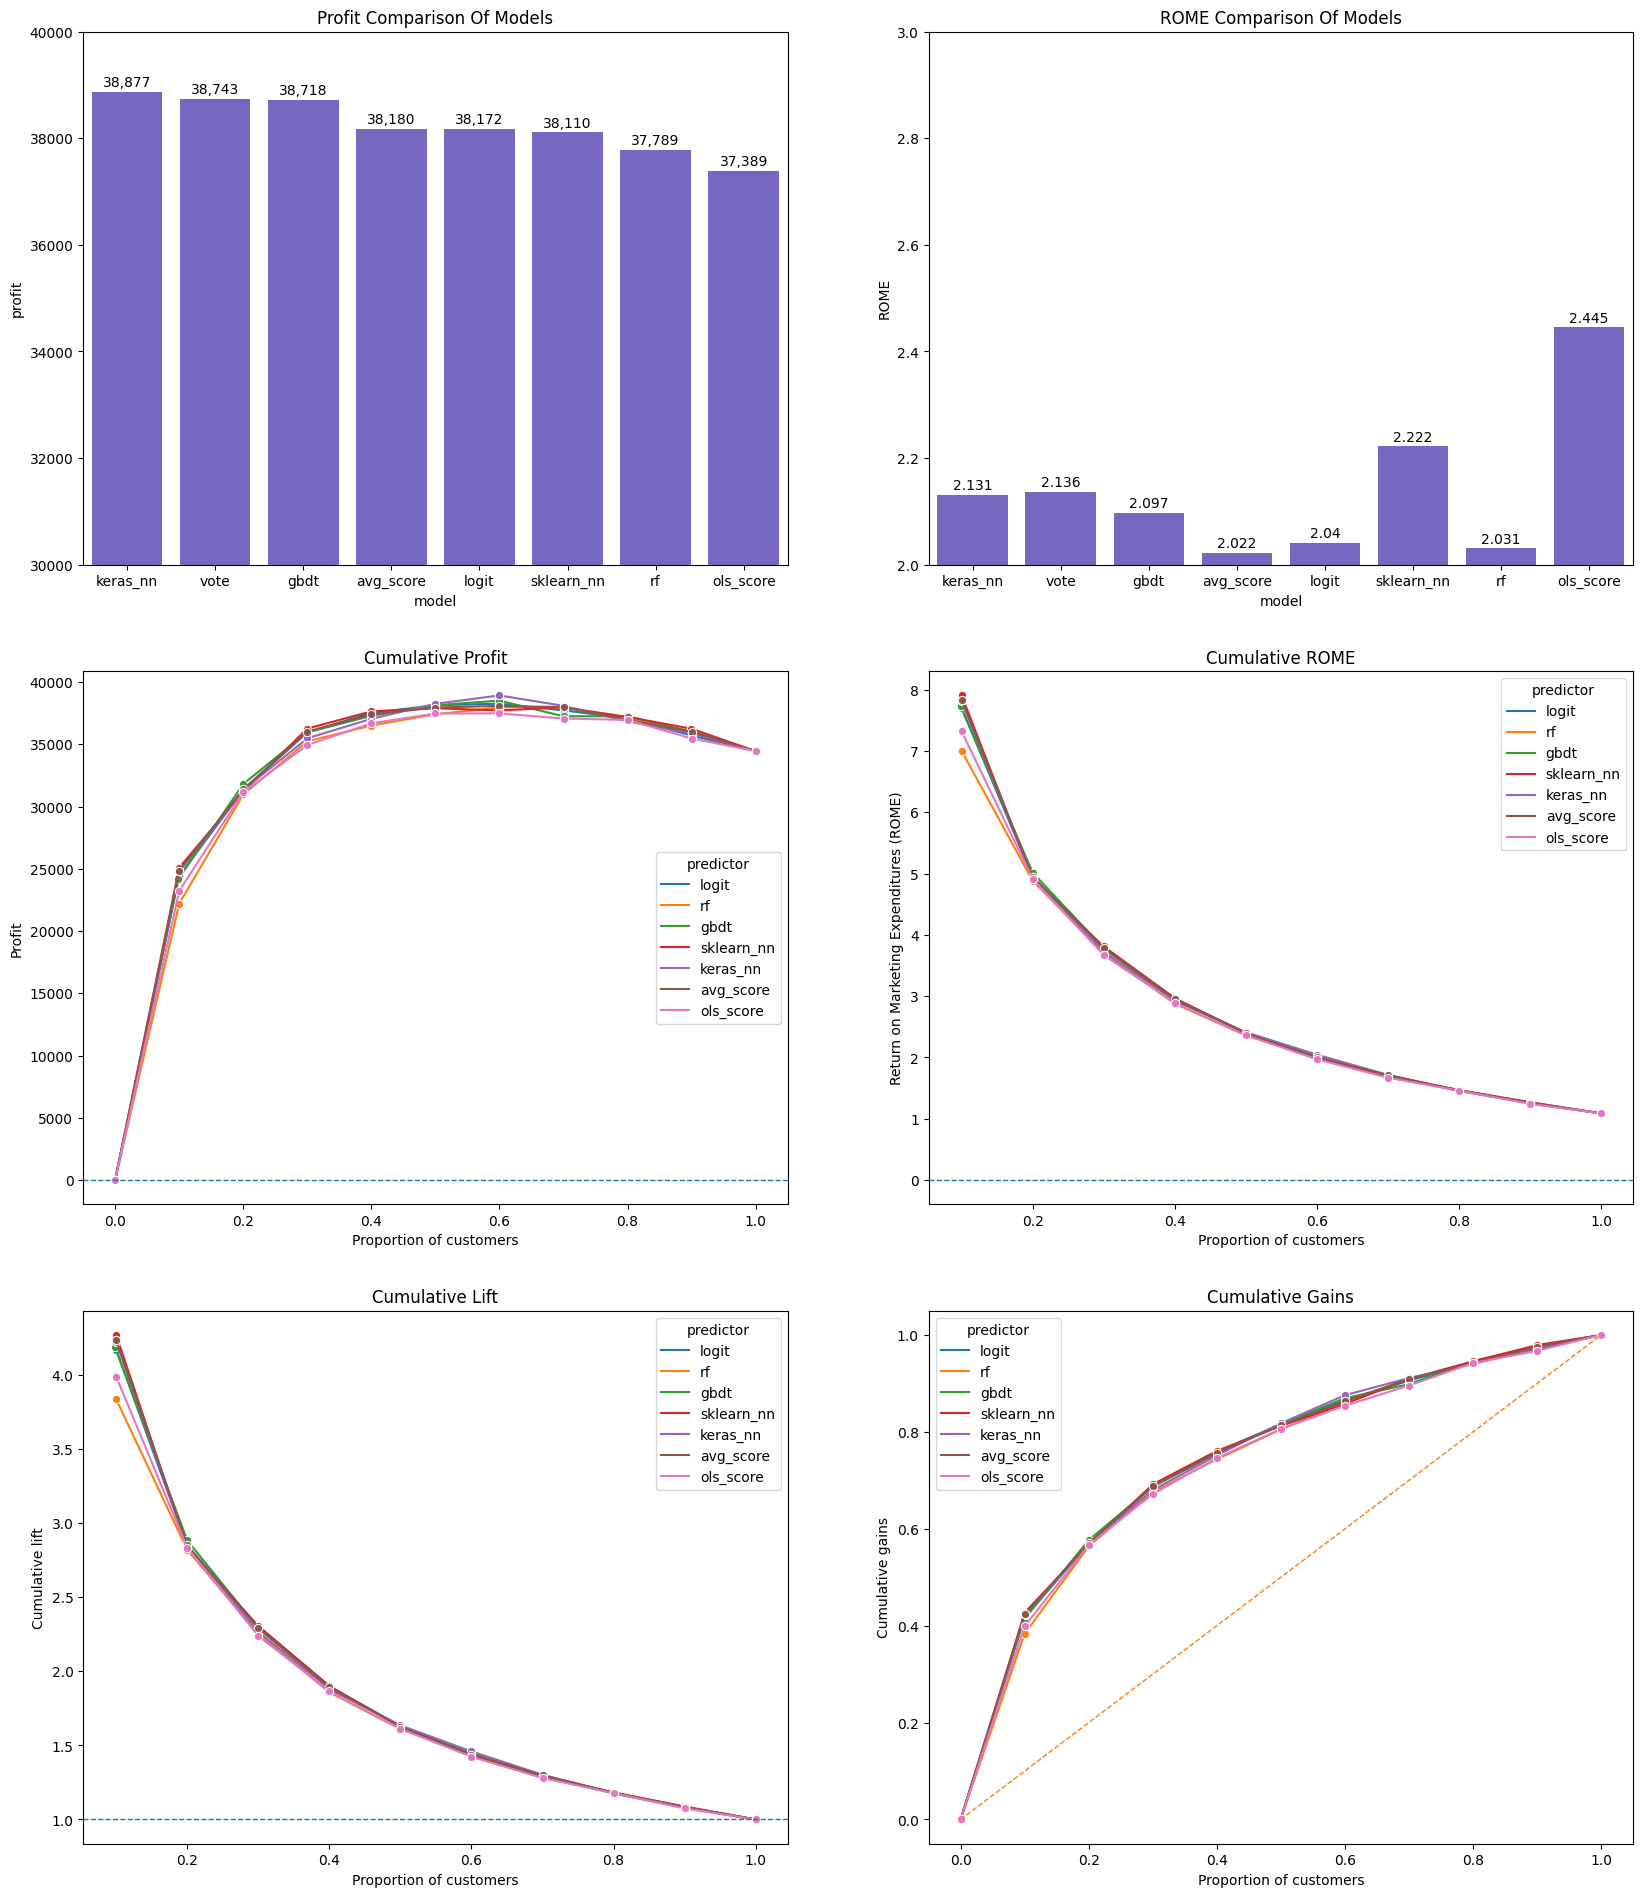

In [36]:
#Profit plot:
plot_data = final_result.copy().reset_index()
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize = (20, 24), dpi = 100)
sns.barplot(x="predictor", y="profit", color="slateblue", data=plot_data, ax = ax1)
ax1.set(xlabel="model", ylabel="profit")
ax1.set(ylim=(30000, 40000))
ax1.set_title("Profit Comparison Of Models")
for index, row in plot_data.iterrows():
    ax1.text(
        row.name, row.profit + 100, f"{int(row.profit):,}", ha="center", color="black"
    )
sns.barplot(x="predictor", y="ROME", color="slateblue", data=plot_data, ax = ax2)
ax2.set(xlabel="model", ylabel="ROME")
ax2.set(ylim=(2, 3))
ax2.set_title("ROME Comparison Of Models")
for index, row in plot_data.iterrows():
    ax2.text(
        row.name, row.ROME + 0.01, f"{round(row.ROME, 3)}", ha="center", color="black"
    )
rsm.profit_plot(df = eval_df.query("training == 0"), rvar = 'res1_yes', lev = 1, pred = ['logit', 'rf', 'gbdt', 'sklearn_nn', 'keras_nn', 'avg_score', 'ols_score'], cost = cost, margin = margin, ax = ax3)
rsm.ROME_plot(df = eval_df.query("training == 0"), rvar = 'res1_yes', lev = 1, pred = ['logit', 'rf', 'gbdt', 'sklearn_nn', 'keras_nn', 'avg_score', 'ols_score'], cost = cost, margin = margin, ax = ax4)
rsm.lift_plot(df = eval_df.query("training == 0"), rvar = 'res1_yes', lev = 1, pred = ['logit', 'rf', 'gbdt', 'sklearn_nn', 'keras_nn', 'avg_score', 'ols_score'], ax = ax5)
rsm.gains_plot(df = eval_df.query("training == 0"), rvar = 'res1_yes', lev = 1, pred = ['logit', 'rf', 'gbdt', 'sklearn_nn', 'keras_nn', 'avg_score', 'ols_score'], ax = ax6)
ax3.set_title("Cumulative Profit")
ax4.set_title("Cumulative ROME")
ax5.set_title("Cumulative Lift")
ax6.set_title("Cumulative Gains")
plt.savefig("images/model_comparison_1")
plt.show()

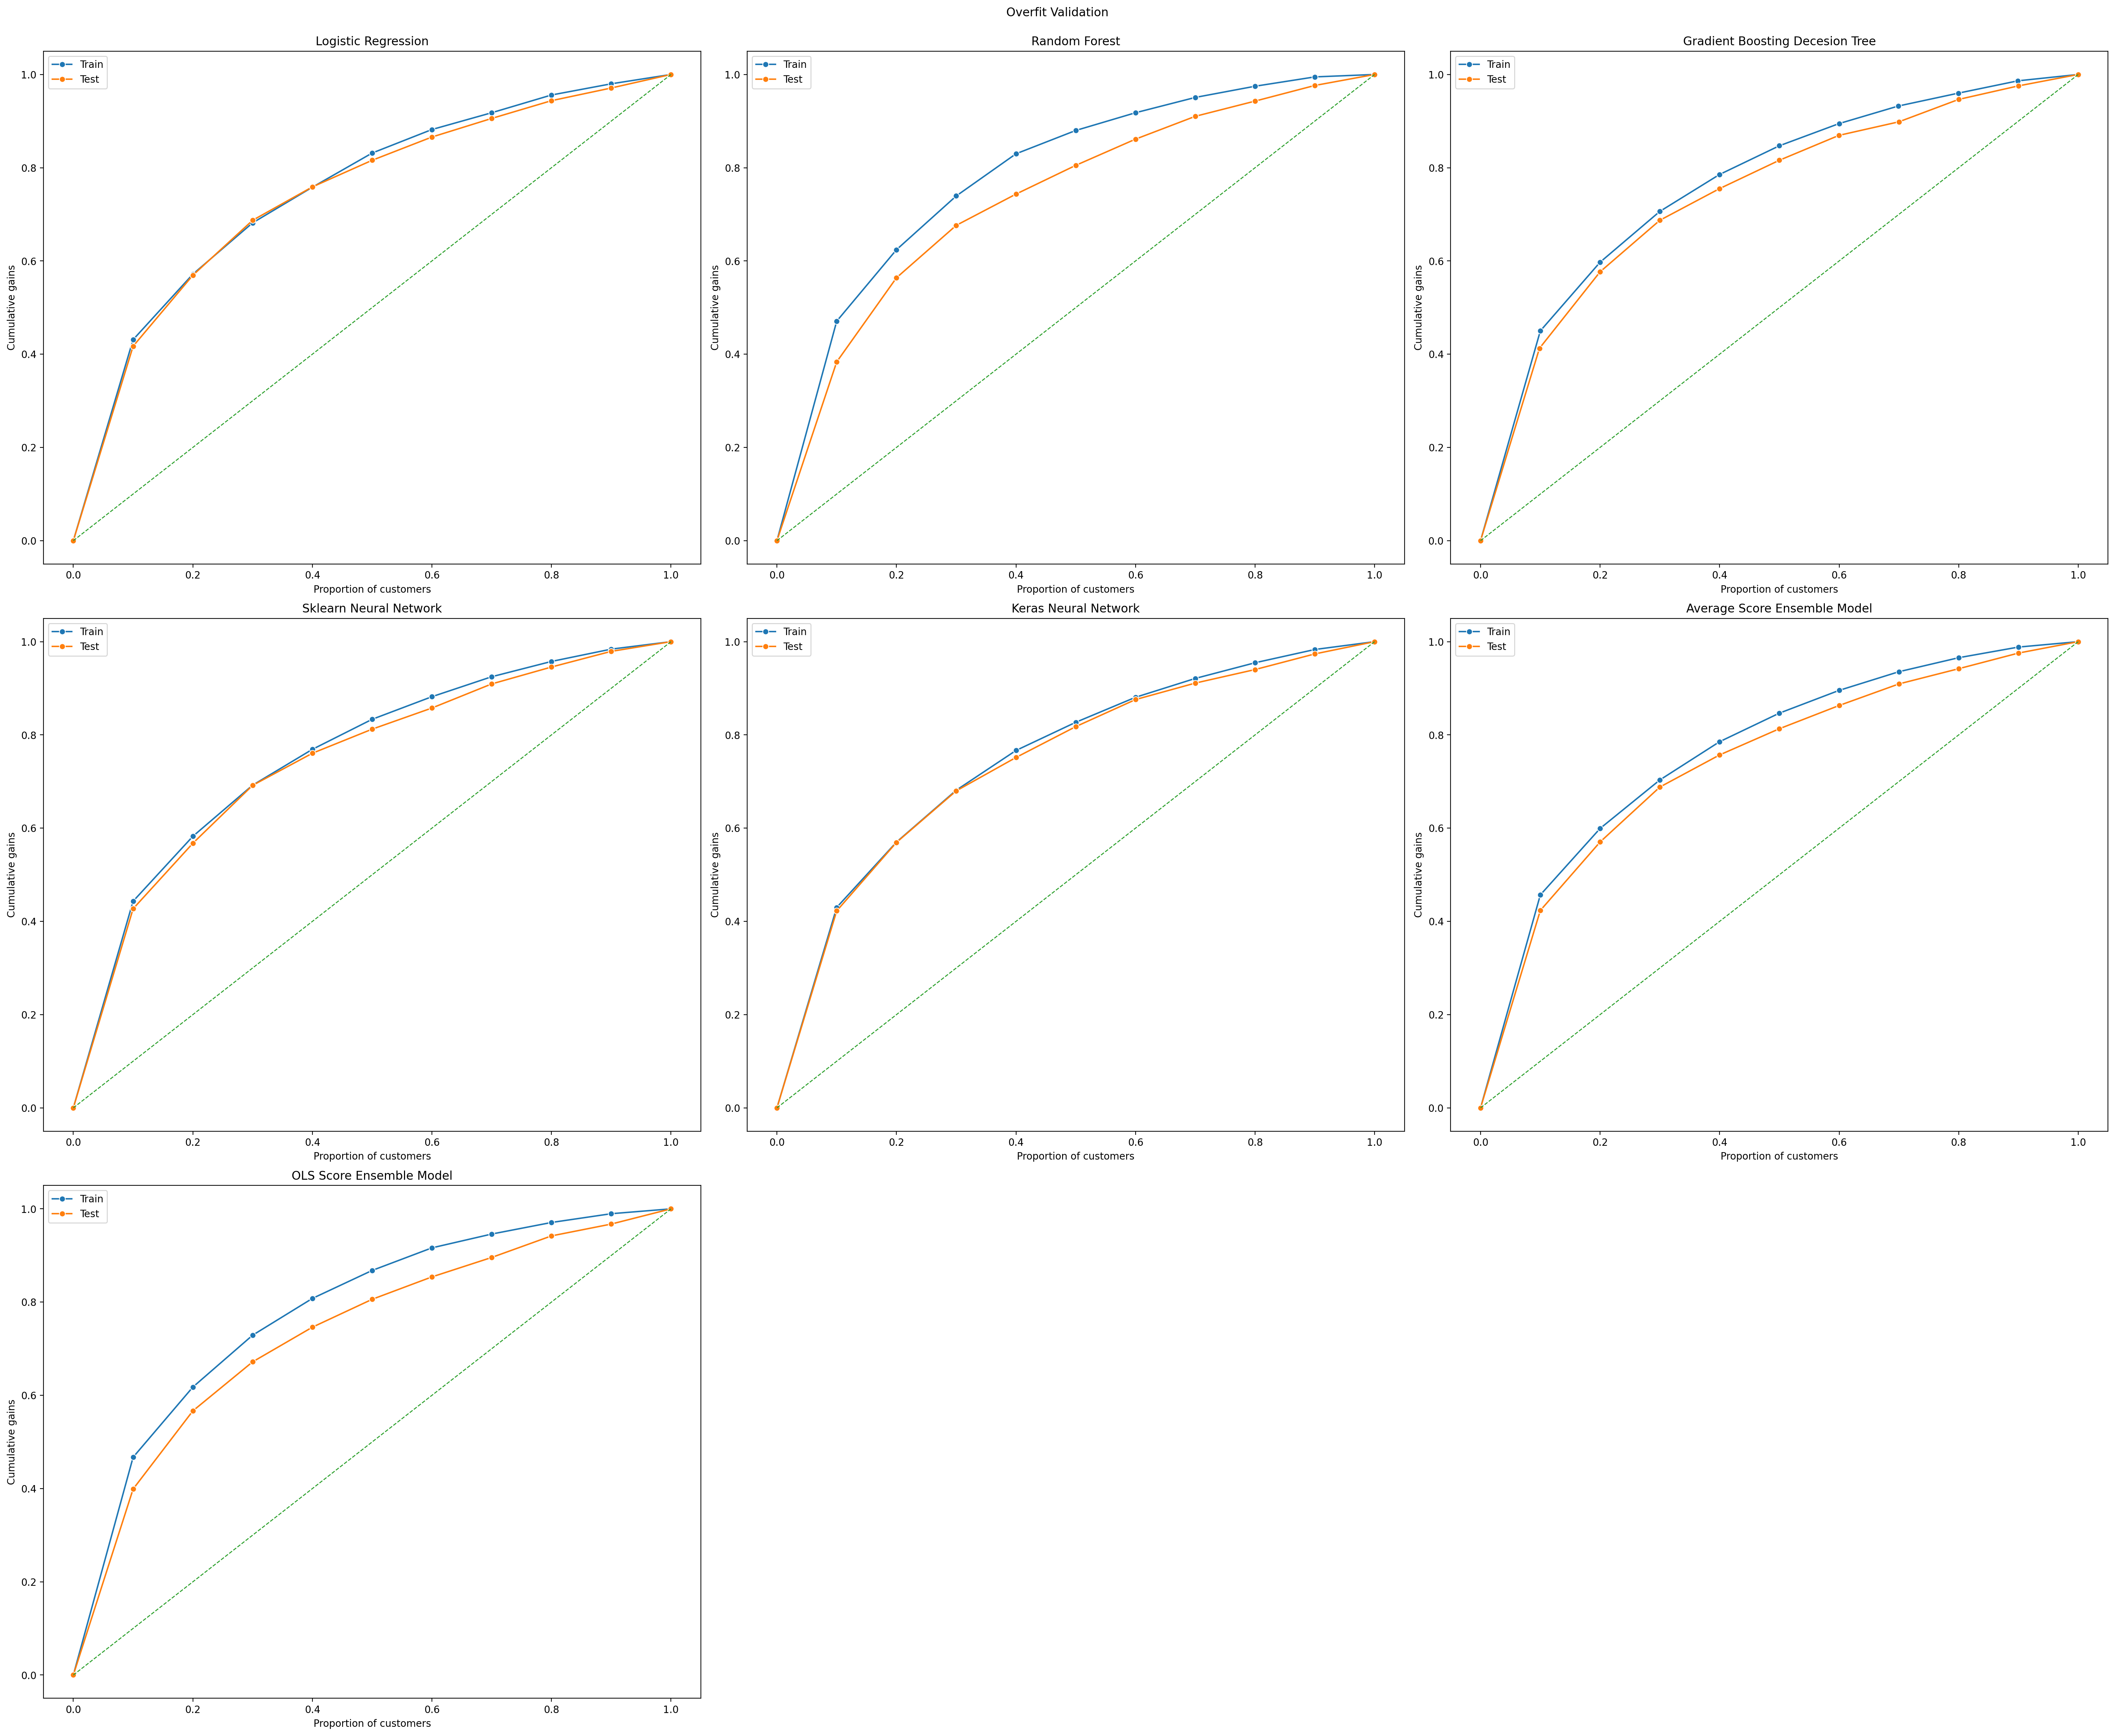

In [37]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize = (30, 25), dpi = 200)
fig.suptitle("Overfit Validation")
rsm.gains_plot(df = eval_df.query("training == 1"), rvar = 'res1_yes', lev = 1, pred = ['logit'], ax = ax1, label = 'Train')
rsm.gains_plot(df = eval_df.query("training == 0"), rvar = 'res1_yes', lev = 1, pred = ['logit'], ax = ax1, label = 'Test')
rsm.gains_plot(df = eval_df.query("training == 1"), rvar = 'res1_yes', lev = 1, pred = ['rf'], ax = ax2, label = 'Train')
rsm.gains_plot(df = eval_df.query("training == 0"), rvar = 'res1_yes', lev = 1, pred = ['rf'], ax = ax2, label = 'Test')
rsm.gains_plot(df = eval_df.query("training == 1"), rvar = 'res1_yes', lev = 1, pred = ['gbdt'], ax = ax3, label = 'Train')
rsm.gains_plot(df = eval_df.query("training == 0"), rvar = 'res1_yes', lev = 1, pred = ['gbdt'], ax = ax3, label = 'Test')
rsm.gains_plot(df = eval_df.query("training == 1"), rvar = 'res1_yes', lev = 1, pred = ['sklearn_nn'], ax = ax4, label = 'Train')
rsm.gains_plot(df = eval_df.query("training == 0"), rvar = 'res1_yes', lev = 1, pred = ['sklearn_nn'], ax = ax4, label = 'Test')
rsm.gains_plot(df = eval_df.query("training == 1"), rvar = 'res1_yes', lev = 1, pred = ['keras_nn'], ax = ax5, label = 'Train')
rsm.gains_plot(df = eval_df.query("training == 0"), rvar = 'res1_yes', lev = 1, pred = ['keras_nn'], ax = ax5, label = 'Test')
rsm.gains_plot(df = eval_df.query("training == 1"), rvar = 'res1_yes', lev = 1, pred = ['avg_score'], ax = ax6, label = 'Train')
rsm.gains_plot(df = eval_df.query("training == 0"), rvar = 'res1_yes', lev = 1, pred = ['avg_score'], ax = ax6, label = 'Test')
rsm.gains_plot(df = eval_df.query("training == 1"), rvar = 'res1_yes', lev = 1, pred = ['ols_score'], ax = ax7, label = 'Train')
rsm.gains_plot(df = eval_df.query("training == 0"), rvar = 'res1_yes', lev = 1, pred = ['ols_score'], ax = ax7, label = 'Test')
ax1.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
ax2.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
ax3.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
ax4.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
ax5.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
ax6.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
ax7.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
ax1.set_title("Logistic Regression")
ax2.set_title("Random Forest")
ax3.set_title("Gradient Boosting Decesion Tree")
ax4.set_title("Sklearn Neural Network")
ax5.set_title("Keras Neural Network")
ax6.set_title("Average Score Ensemble Model")
ax7.set_title("OLS Score Ensemble Model")
fig.delaxes(ax8)
fig.delaxes(ax9)
fig.tight_layout(pad = 1, h_pad = 1)
fig.subplots_adjust(top = 0.955)
plt.savefig("images/model_comparison")
plt.show()

### Predict The Result

In [38]:
def vote_wave2_prediction(x, breakeven):
    pos = np.where(x.logit > breakeven, 1, 0) +\
        np.where(x.rf > breakeven, 1, 0) +\
        np.where(x.gbdt > breakeven, 1, 0) +\
        np.where(x.sklearn_nn > breakeven, 1, 0) +\
        np.where(x.keras_nn > breakeven, 1, 0)
    
    if pos > 5 - pos and x.res1_yes == 0:
        return True
    
    else: return False

In [39]:
eval_df['mailto_wave2'] = eval_df.apply(lambda x: vote_wave2_prediction(x, breakeven * 2), axis = 1)

In [40]:
eval_df.query("training == 0")[['id', 'mailto_wave2']].to_csv("data/Xinshu_Qi_Chenyuan_Xiangyu_WonderFourEver.csv", index = False)